In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Load dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) / 255.0
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) / 255.0

## Data exploration

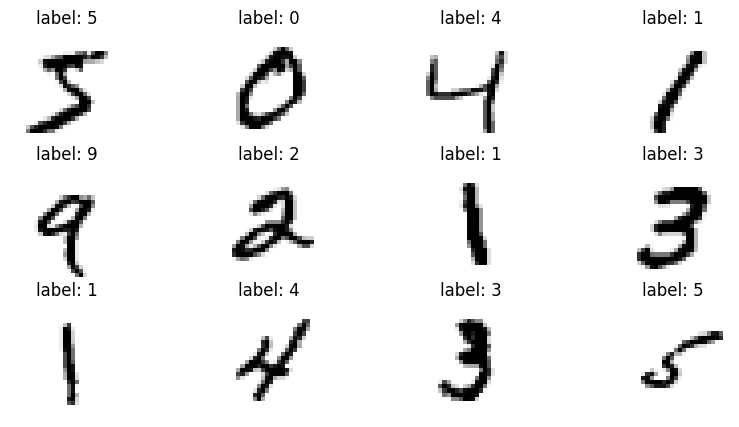

In [3]:
images_and_labels = list(zip(x_train,  y_train))
figure, axes = plt.subplots(3, 4, figsize=(10, 5))

for index, (image, label) in enumerate(images_and_labels[:12]):
  row = index // 4
  col = index % 4
  axis = axes[row][col]

  axis.axis('off')
  axis.imshow(image.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
  axis.set_title(f'label: {label}')

In [4]:
images = np.concatenate([x_train, x_test], axis=0)

pad_left = []
pad_right = []
pad_top = []
pad_bottom = []

for image in images:
  coords = cv2.findNonZero(image)
  x, y, w, h = cv2.boundingRect(coords)

  pad_left.append(x)
  pad_right.append(28 - w - x)
  pad_top.append(y)
  pad_bottom.append(28 - h - y)

pad_left = np.array(pad_left)
pad_right = np.array(pad_right)
pad_top = np.array(pad_top)
pad_bottom = np.array(pad_bottom)

np.median(pad_left), np.median(pad_right), np.median(pad_top), np.median(pad_bottom)

(6.0, 6.0, 5.0, 3.0)

## Data augmentation

In [5]:
# Train
mean_px = x_train.mean()
std_px = x_train.std()
x_train = (x_train - mean_px) / std_px

# Test
mean_px = x_test.mean()
std_px = x_test.std()
x_test = (x_test - mean_px) / std_px

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

data_generator = keras.preprocessing.image.ImageDataGenerator(
  rotation_range=10,
  zoom_range=0.1,
  width_shift_range=0.1,
  height_shift_range=0.1,
  validation_split=0.2,
)

data_generator.fit(x_train)

train_generator = data_generator.flow(x_train, y_train, batch_size=32, subset='training')
validation_generator = data_generator.flow(x_train, y_train, batch_size=32, subset='validation')

## Model

In [7]:
model = keras.models.Sequential([
  keras.layers.Conv2D(
    32,
    5,
    strides=1,
    input_shape=(28, 28, 1),
    activation='relu',
    kernel_regularizer=keras.regularizers.l2(0.0005),
  ),
  keras.layers.Conv2D(
    32,
    5,
    strides=1,
    activation='relu',
  ),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(pool_size=2, strides=2),
  keras.layers.Dropout(0.25),

  keras.layers.Conv2D(
      64,
      3,
      strides=1,
      activation='relu',
      kernel_regularizer=keras.regularizers.l2(0.0005),
  ),
  keras.layers.Conv2D(
      64,
      3,
      strides=1,
      activation='relu',
  ),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(pool_size=2, strides=2),
  keras.layers.Dropout(0.25),

  keras.layers.Flatten(),

  keras.layers.Dense(256, activation='relu'),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dropout(0.25),

  keras.layers.Dense(128, activation='relu'),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dropout(0.25),

  keras.layers.Dense(64, activation='relu'),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dropout(0.25),

  keras.layers.Dense(10, activation='softmax')
])

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [8]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [9]:
callbacks = [
  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3),
  keras.callbacks.ModelCheckpoint('mnist.h5', save_best_only=True),
]

In [10]:
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  use_multiprocessing=True,
  batch_size=32,
  epochs=30,
  workers=-1,
  callbacks=callbacks,
)

Epoch 1/30


2023-05-10 15:09:37.738231: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1500/1500 [==============================] - 47s 30ms/step - loss: 0.7999 - accuracy: 0.7625 - val_loss: 0.2397 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 2/30
1500/1500 [==============================] - 45s 30ms/step - loss: 0.2455 - accuracy: 0.9355 - val_loss: 0.1327 - val_accuracy: 0.9689 - lr: 0.0010
Epoch 3/30
1500/1500 [==============================] - 46s 31ms/step - loss: 0.1769 - accuracy: 0.9548 - val_loss: 0.1422 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 4/30
1500/1500 [==============================] - 46s 30ms/step - loss: 0.1471 - accuracy: 0.9643 - val_loss: 0.0919 - val_accuracy: 0.9804 - lr: 0.0010
Epoch 5/30
1500/1500 [==============================] - 46s 30ms/step - loss: 0.1306 - accuracy: 0.9683 - val_loss: 0.0710 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 6/30
1500/1500 [==============================] - 46s 31ms/step - loss: 0.1226 - accuracy: 0.9701 - val_loss: 0.0840 - val_accuracy: 0.9811 - lr: 0.0010
Epoch 7/30
1500/1500 [==============================] - 4

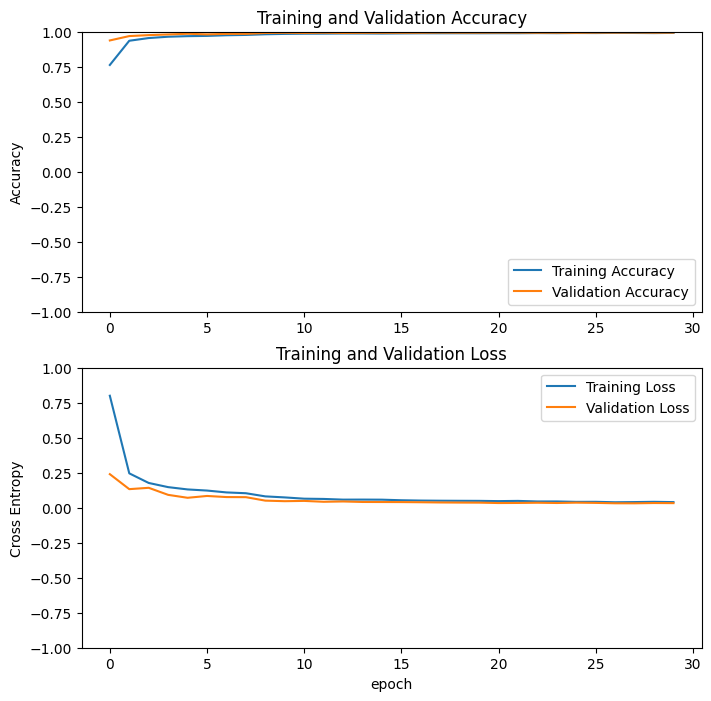

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
model = keras.saving.load_model('mnist.h5')

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.0237 - accuracy: 0.9959


[0.023665692657232285, 0.9958999752998352]